# Polar plot things

- gemiddelde polar plot laten zien
- gemiddelde plot vergelijken met gemiddelde per training
- gemiddelde plot voor verschillende vermogensranges
- relatie tussen vermogen, cadence en peak power

## Initialization and retrieving data

In [1]:
from datetime import date

from sklearn import linear_model
from wblib.models import WattbikeDataFrame

%matplotlib inline

In [2]:
user_id = 'u-1756bbba7e2a350'

In [3]:
wdf = WattbikeDataFrame()
wdf = wdf.load_for_user(user_id, after=date(2017, 9, 1), before=date(2017, 11, 25))

/Users/aart/Dropbox/Documents/projects/publications/venv/lib/python3.6/site-packages/wblib/models.py:161: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.performance_states = {}


In [4]:
print('Memory usage of all data: {}MB'.format(int(round(wdf.memory_usage().sum()/1000000))))

Memory usage of all data: 183MB


## Average Polar Plot

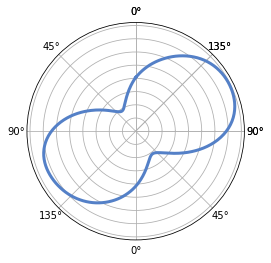

In [8]:
wdf.plot.polar()

## Average Polar Plot per session

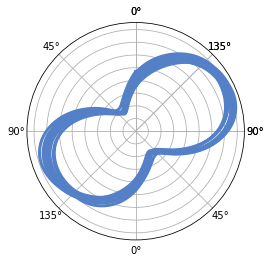

In [9]:
for session_id in set(wdf.session_id):
    a = wdf.loc[wdf.session_id == session_id].plot.polar()

## Average polar plot for power ranges

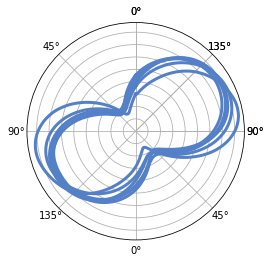

In [10]:
min_power = 0
max_power = 100
while max_power <= 600:
    wdf.loc[wdf.power.between(min_power, max_power)].plot.polar()
    min_power += 100
    max_power += 100

## Relationship between power, cadence and peak angle

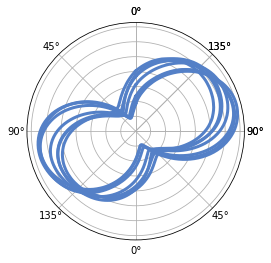

In [11]:
min_cadence = 50
max_cadence = 60
while max_cadence <= 120:
    wdf.loc[wdf.cadence.between(min_cadence, max_cadence)].plot.polar()
    min_cadence += 10
    max_cadence += 10

Relationship between power and cadence and peak force angle, calculated with multiple linear regression:

In [29]:
reg = linear_model.LinearRegression()
wdf_dropped_na = wdf[['power', 'cadence', 'anglePeakForce_leftAngle']].dropna()
reg.fit (wdf_dropped_na[['power', 'cadence']].as_matrix(), wdf_dropped_na.anglePeakForce_leftAngle.as_matrix())
reg.coef_

array([-0.0288664 ,  0.57737325])

Relationship between power and cadence, calculated with linear regression:

In [21]:
reg = linear_model.LinearRegression()
wdf_dropped_na = wdf[['power', 'cadence']].dropna()
reg.fit (wdf_dropped_na[['power']].as_matrix(), wdf_dropped_na.cadence.as_matrix())
reg.coef_

array([ 0.05106876])

In [24]:
reg.__dict__

{'_residues': 19361436.760237236,
 'coef_': array([-0.0288664 ,  0.57737325]),
 'copy_X': True,
 'fit_intercept': True,
 'intercept_': 72.688377364706909,
 'n_jobs': 1,
 'normalize': False,
 'rank_': 2,
 'singular_': array([ 31499.1166932 ,   2984.98771889])}

In [32]:
reg = LinearRegression()
wdf_dropped_na = wdf[['power', 'cadence', 'anglePeakForce_leftAngle']].dropna()
reg.fit (wdf_dropped_na[['power', 'cadence']].as_matrix(), wdf_dropped_na.anglePeakForce_leftAngle.as_matrix())
reg.coef_

IndexError: tuple index out of range

In [31]:
reg.__dict__

{'_residues': 19361436.760237236,
 'coef_': array([-0.0288664 ,  0.57737325]),
 'copy_X': True,
 'fit_intercept': True,
 'intercept_': 72.688377364706909,
 'n_jobs': 1,
 'normalize': False,
 'rank_': 2,
 'singular_': array([ 31499.1166932 ,   2984.98771889])}

In [35]:
# from https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9
import statsmodels.api as sm

selected_data = wdf[['power', 'cadence', 'anglePeakForce_leftAngle']].dropna().sample(n=1000)
#selected_data = wdf_dropped_na.loc[wdf_dropped_na.power.between(100, 300)]

X = selected_data[['power', 'cadence']]
X = sm.add_constant(X)
y = selected_data['anglePeakForce_leftAngle']

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     anglePeakForce_leftAngle   R-squared:                       0.134
Model:                                  OLS   Adj. R-squared:                  0.132
Method:                       Least Squares   F-statistic:                     77.21
Date:                      Sun, 26 Nov 2017   Prob (F-statistic):           6.67e-32
Time:                              13:32:49   Log-Likelihood:                -4356.1
No. Observations:                      1000   AIC:                             8718.
Df Residuals:                           997   BIC:                             8733.
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.2251      3.919     18.431      0.000      64.535      79.915
power         -0.0313      0.005     -6.130      0.000      -0.041      -0.021
cadence        0.5844      0.047     12.363      0.000       0.492       0.677
==============================================================================
Omnibus:                      352.340   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5070.941
Skew:                          -1.204   Prob(JB):                         0.00
Kurtosis:                      13.766   Cond. No.                     1.89e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This analysis makes it clear that both power and cadence have a signficant relationship with the peak force angle: For both independent variables the p value is <0.05. With a large number of samples like this (n=58211) a significant relationship between variables is highly likely so in this case it is more interesting to look at the effect sizes, the coefficients: For power this relationship is quite small: For every 1 Watt increase in power the peak force angle decreases by 0.03 degree. For cadence this relationship is larger: For every 1 rpm increase in cadence the peak force angle increases by 0.58. This data suggests that although power has a significant relationship with peak force angle, more variation in peak force angle is explained by changes in cadence.
The "goodness of fit" (represented by the R^2 of 0.134) is quite low, indicating that the model cannot be used to get accurate predictions for peak force angle based on power and cadence. Although this is speculation, a possible cause for the low goodness of fit might be the amount of noise in the data.

## Discussion

One confounding factor in the data is that it contains revolutions in both sitting and standing positions. Standing positions seem to increase the peak force angle by a lot (I will publish an article on later) which might add noise to the data.
Removing samples where power is really low or high might remove some noise which could improve model estimates.
In large datasets it is highly likely to find significant relationships between variables although their effect sizes might be really small.